In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
data = pd.read_csv('../accre_project-malted_milk_balls/accre-gpu-jobs-2022-v2.csv', on_bad_lines='skip')

In [3]:
#Only include jobs that have been completed, 'STATE' = COMPLETED
#Exclude jobs with memory usage = 0 Mb
data = (data[
    (data['STATE']=='COMPLETED') & 
    (data['USEDMEM']!='0') &
    (data['USEDMEM']!='0.00M')
    ])

In [4]:
def str2seconds(timestr):
    if len(timestr) == 8:
        # split in hh, mm, ss
        hh, mm, ss = timestr.split(':')
        return int(hh) * 3600 + int(mm) * 60 + int(ss)
    else:
        d = timestr[0]
        dropday = timestr[2:]
        hh, mm, ss = dropday.split(':')
        return int(d) *3600*24 + int(hh) * 3600 + int(mm) * 60 + int(ss)

In [5]:
#First take times and convert to seconds
usedtime = data['USEDTIME']
reqtime = data['REQTIME']
usedtime_seconds = []
reqtime_seconds = []

for string in usedtime:
    usedtime_seconds.append(str2seconds(string))

for string in reqtime:
    reqtime_seconds.append(str2seconds(string))

In [6]:
data['USEDMEM'] = data['USEDMEM'].str.strip('M').astype(float)

In [7]:
data['req_time_seconds'] = reqtime_seconds
data['used_time_seconds'] = usedtime_seconds

#Get used memory per GPU for each job 
data['USEDMEM_per_GPU'] = data['USEDMEM']/data['GPUS']
#Weight the used memory based on amount of time the request was 
data['weighted_used_mem'] = (data['USEDMEM_per_GPU']*data['used_time_seconds'])/sum(usedtime_seconds)

In [8]:
#Group by partition name for seperate analysis if needed
turing = data[data['PARTITION'] == 'turing']
maxwell = data[data['PARTITION'] == 'maxwell']
pascal = data[data['PARTITION'] == 'pascal']

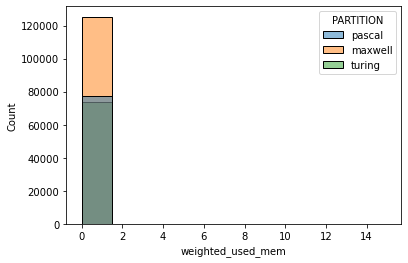

In [38]:
sns.histplot(x = data['weighted_used_mem'], hue = data['PARTITION'], bins = 10)
plt.show()

# Skewed Data 
This dataset is extremely skewed so lets set the axes to log scale. 

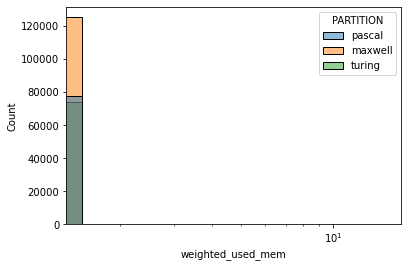

In [10]:
histogram = sns.histplot(x = data['weighted_used_mem'], hue = data['PARTITION'], bins = 10)
histogram.set(xscale='log')
plt.show()

We can see that that the histogram is still the same so lets look at the box plot and CDF represenatations of the data to get a closer picture of each of the partitions. 

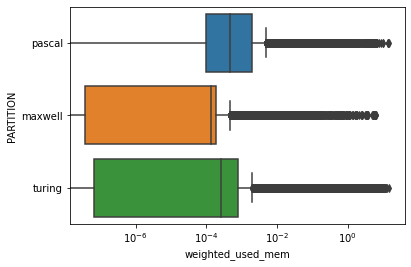

In [11]:
boxplot = sns.boxplot(x = data['weighted_used_mem'], y = data['PARTITION'])
boxplot.set(xscale= 'log')
plt.show()

In [39]:
data['weighted_used_mem'].groupby(data['PARTITION']).describe()

,count,mean,std,min,25%,50%,75%,max
PARTITION,,,,,,,,
maxwell,125370.0,0.002595,0.068776,0.0,3.721905e-08,0.000131,0.000186,6.152163
pascal,77769.0,0.018569,0.205759,0.0,1.008850e-04,0.000460,0.001988,14.197097
turing,74336.0,0.043253,0.412154,0.0,6.504556e-08,0.000263,0.000803,14.952076


We can see that each of the partitions have very simliar medians for amount of data used per GPU.   

In [26]:
#Lets look at the number of outliers for each of the partition distributions
df_quant = data.pivot(values=['weighted_used_mem'], columns=['PARTITION'])
Q1 = df_quant.quantile(0.25)
Q3 = df_quant.quantile(0.75)
IQR = Q3 - Q1

In [36]:
#Calculate the percentage of number of outliers to the total number of jobs in that distribution
outliers = ((df_quant < (Q1 - 1.5 * IQR)) | (df_quant > (Q3 + 1.5 * IQR))).sum()
print('The number of outliers for each of the partitions:\n', outliers)
percentage_outliers = outliers/[len(maxwell), len(pascal), len(turing)]
print('The percentage of outliers to total number of jobs per partition:\n', percentage_outliers)


The number of outliers for each of the partitions:
                    PARTITION
weighted_used_mem  maxwell      10946
                   pascal       17430
                   turing       14888
dtype: int64
The percentage of outliers to total number of jobs per partition:
                    PARTITION
weighted_used_mem  maxwell      0.087310
                   pascal       0.224125
                   turing       0.200280
dtype: float64


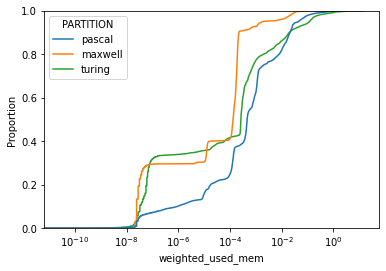

In [14]:
cdf_plot = sns.ecdfplot(x = data['weighted_used_mem'], hue = data['PARTITION'])
cdf_plot.set(xscale= 'log')
plt.show()